In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [5]:
FOLDER = 'images/'

def get_img(name):
    flow_img = cv.imread(FOLDER + name)
    final_img = cv.imread(FOLDER + name, flow_img.shape[0] * 2)
    plt.imshow(final_img)
    return final_img

In [6]:
images = os.listdir(FOLDER)

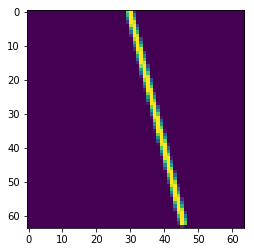

In [7]:
img_new = get_img('test_PVP_left.jpg')

In [8]:
def merge_h(h1, h2):       
    height = h1.shape[0]
    width = 1 if len(h1.shape) == 1 else h1.shape[1]
    n0 = width * 2
    r = (width - 1) / (n0 - 1)
    h1, h2 = h1.reshape((height, width)), h2.reshape((height, width))
    result = np.zeros((height, n0))
    for t in range(n0):
        t0 = int(t * r)
        s = t - t0
        result[:, t] = h1[:, t0] + np.concatenate([h2[s: height, t0], h2[0: s, t0]], axis=0)
    return result

def fast_Hough_transform(Picture):
    """
    Алгоритм быстрого преобразования ХАФА для поиска преимущественно горизонтальных прямых с наклоном вниз.
    """
    n = Picture.shape[1]
    if n < 2:
        return Picture[:, 0]
    else:
        return merge_h(fast_Hough_transform(Picture[:, 0: int(n / 2)]), fast_Hough_transform(Picture[:, int(n / 2): n]))

In [9]:
def find_max(picture):
    result = 0
    a, b = picture.shape
    s, t = 0., 0.
    for i in range(a):
        for j in range(b):
            if picture[i, j] > result:
                result = picture[i, j]
                s = i
                t = j    
    return result, tuple((s, t))
    
def find_point(n, s, t):
    x = round((n - s) * n / t)
    return x
    
# Рисует линию в координатах для ПГП вниз   
def draw_line(picture, s, t):
    image = picture.copy()
    height, width = picture.shape
    lineThickness = 2
    if s + t > height:
        x_0 = find_point(height, s, t)     #, x_0 = 0
        zero_matrix = np.zeros((height, width))
        stacked_upper = np.vstack([zero_matrix, picture])[s:s+height, :]
        stacked_lower = np.vstack([picture, zero_matrix])[s:s+height, :]
        max_up = find_max(fast_Hough_transform(stacked_upper)), 
        max_low = find_max(fast_Hough_transform(stacked_lower))
        if max_up > max_low:
            cv.line(image, (x_0, 0), (width - 1, s + t - height), (64, 0, 0), lineThickness)
        else:
            cv.line(image, (x_0, height), (0, s), (64, 0, 0), lineThickness)
        plt.imshow(image)
        
    else:
        plt.imshow(cv.line(image, (0, s), (width - 1, s + t), (64, 0, 0), lineThickness))
    return image

In [10]:
def ht_PVP_left_and_find_max(img_PVP_left, draw=0):
    #ПВП влево
    img_flipped = img_PVP_left[::-1, ]
    img_flipped = np.rot90(img_flipped, 3)
    obraz = fast_Hough_transform(img_flipped)
    rez3, (s, t) = find_max(obraz)
        
    if draw != 0:
        img_with_line = draw_line(img_flipped, s, t)
        plt.imshow(np.rot90(img_with_line, 1)[::-1,]);
    else:
        return rez3, obraz

In [11]:
def ht_PVP_right_and_find_max(img_PVP_right, draw=0):
    img_flipped = np.rot90(img_PVP_right, 3)
    obraz = fast_Hough_transform(img_flipped)
    rez2, (s, t) = find_max(obraz)

    if draw != 0:
        img_with_line = draw_line(img_flipped, s, t)
        plt.imshow(np.rot90(img_with_line, 1));
    else:
        return rez2, obraz

In [12]:
def ht_PGP_up_and_find_max(img_PGP_up, draw=0):
    #ПГП вверх
    img_flipped = img_PGP_up[::-1, ]
    obraz = fast_Hough_transform(img_flipped)
    rez1, (s, t) = find_max(obraz)

    if draw != 0:
        img_with_line = draw_line(img_flipped, s, t)
        plt.imshow(img_with_line[::-1,]);
    else:
        return rez1, obraz

In [25]:
def ht_PGP_down_and_find_max(img_PGP_down, draw=0):
    img_flipped = img_PGP_down[::-1, ]
    obraz = fast_Hough_transform(img_PGP_down)
    rez1, (s, t) = find_max(obraz)


    if draw != 0:
        img_with_line = draw_line(img_PGP_down, s, t)
        plt.imshow(img_with_line);
    else:
        return rez1, obraz

In [26]:
transforms = {
    'PGP_up' : ht_PGP_up_and_find_max,
    'PGP_down' : ht_PGP_down_and_find_max,
    'PVP_left' : ht_PVP_left_and_find_max,
    'PVP_right' : ht_PVP_right_and_find_max
}

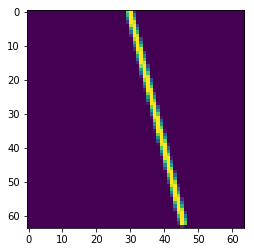

In [27]:
img_new = get_img('test_PVP_left.jpg')

In [39]:
max_ = 0

images = []

for key in transforms.keys():
    #print(transforms[key](img_new))
    max_hft, obr = transforms[key](img_new)
    images.append(obr)
    if max_hft > max_:
        result_transformation = key
        max_, obr = transforms[key](img_new)

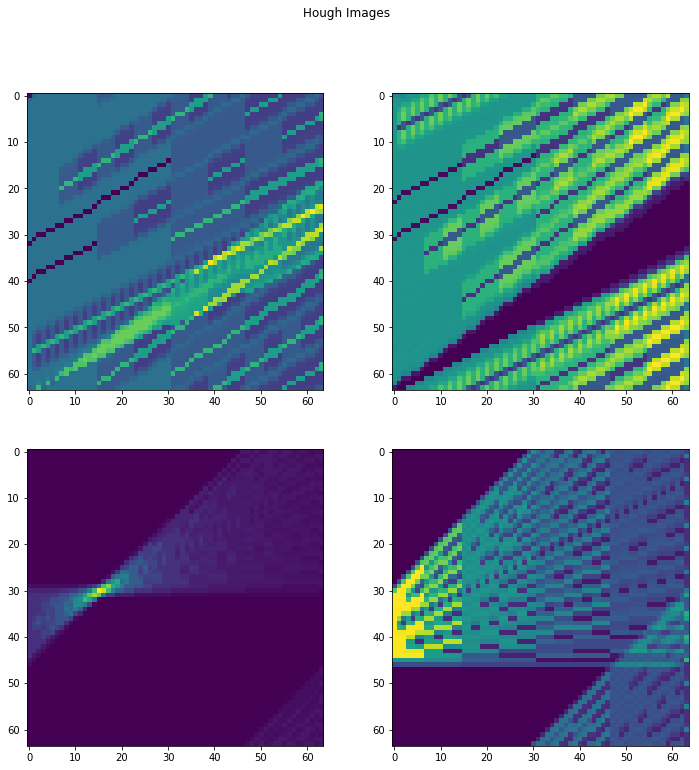

In [51]:
fig, axes = plt.subplots(2, 2)

for i in range(4):
    axes[i // 2][i % 2].imshow(images[i])
    
    
fig.set_figwidth(12)    
fig.set_figheight(12)
fig.suptitle("Hough Images")
plt.show()

С помощью алгоритма БПХ и найденных координат данная прямая прорисована.

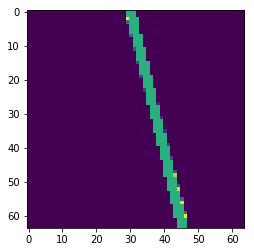

In [31]:
transforms[result_transformation](img_new, draw=1)